In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from termcolor import colored

In [3]:
import book_format
book_format.set_style()
import kf_book.gh_internal as gh
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars

Please install SymPy before continuing. See chapter 0 for instructions.


In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
method = "1"

# Data Preprocessing

In [6]:
def loader():
    # Load the measured value into this.
    weights1 = np.loadtxt("../tracking_data/method1music.txt", delimiter=",")
    weights = list(weights1)
    
    # Load the actual data into this
    actual1 = np.loadtxt("../tracking_data/true_vals.txt", delimiter=",")
    actual = list(actual1)
    
    # Output the measured values as a list of N-D coordinates.
    return [weights, actual]

In [7]:
def initialize(weights):
    # Pre-process and calculate the intial values into this variable
    weight = 0
    gain_rate = 0
    
    # Output the initial estimates where
    # weight is a N-D coordinate and gain_rate is a N-D gradient.
    return [weight, gain_rate]

In [8]:
# This is the measured data got from sensors
# This is the actual data being given as annotations or label for prediction accuracy check
# Size of Actual Data = 1 + Size of Measured Data (according to convention here)

# weights = loader() # loading the data
[weights, actual] = loader()
weights = weights[1:]

# Objective Functions for Comparison

In [9]:
# Function to calculate mean squared distance between the estimated value and actual value
def msd(estimates, actual):
    msd = 0
    for i in range(len(actual)):
        msd += (estimates[i]-actual[i])**2;
    msd = msd / len(actual)
    msd = math.sqrt(msd)
    return msd

In [10]:
# Function to calculate absolute distance between the estimated value and actual value
def asd(estimates, actual):
    msd = 0
    for i in range(len(actual)):
        msd += abs(estimates[i]-actual[i]);
    msd = msd / len(actual)
    return msd

In [11]:
# Function to calculate KL Divergence of L1 normalized estimated and actual values
def kl_divergence(a, b):
    sum1 = sum(a)
    sum2 = sum(b)
    for i in range(len(a)):
        a[i] = a[i] / sum1
    for i in range(len(b)):
        b[i] = b[i] / sum2
    return sum(a[i] * np.log(a[i]/b[i]) for i in range(len(a)))

In [12]:
def objective(a, b):
    o1 = msd(a, b)
    o2 = asd(a, b)
    o3 = kl_divergence(a.copy(), b.copy())
    o4 = kl_divergence(b.copy(), a.copy())
    print("The Mean Squared Distance of estimates and actual path is "+ colored(o1, 'red', attrs=['bold','underline']))
    print("The Absolute Squared Distance of estimates and actual path is "+ colored(o2, 'red', attrs=['bold']))
    print("The KL Divergence between estimates and actual path is "+ colored(o3, 'red', attrs=['bold','underline']))
    print("The Inverse KL Divergence between estimates and actual path is "+ colored(o4, 'red', attrs=['bold']))
    return

In [13]:
[measured, acting] = loader()
objective(measured, acting)

The Mean Squared Distance of estimates and actual path is 38.85376606220404
The Absolute Squared Distance of estimates and actual path is 17.697379749087215
The KL Divergence between estimates and actual path is 0.05621710129071406
The Inverse KL Divergence between estimates and actual path is 0.049970789581922206


# g-h Filter

## Approach 1 - Plain Algorithm

### Algorithm

In [14]:
def gh_filter(weights, weight, gain_rate, weight_scale, gain_scale, do_print=False):
    estimates, predictions = [weight], []
    
    for z in weights:
        # prediction step
        weight = weight + gain_rate * time_step
        predictions.append(weight)
        predicted_weight = weight

        # update step
        residual = z - weight
        gain_rate = gain_rate + gain_scale * (residual/time_step)
        weight = weight + weight_scale * residual
        estimates.append(weight)
        estimated_weight = weight
        
        # Optional Printing Step
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)
    
    return [estimates, predictions]

### Example 1

In [15]:
# Intial Hypothesis made by some pre-processing of the measurement data
# weight, gain_rate = initialize(weights) # initializing the filter output
weight = weights[0]  # initial position
gain_rate = 1.0  # initial gain

In [16]:
# Time Step on which data is being measured with respect to the the time step on which initial
# gain is being assumed.
time_step = 1.0  # day

# The estimated value is kept something in between the predicted value and the measured value.
# scale = 0.5 means equal likelihood to both measurement and prediction.
# scale > 0.5 means measurement is given more likelihood of being true.
# scale < 0.5 means prediction is given more likelihood of being true.
weight_scale = 4.0/100

# The gain value is updated to something in between the initial value and the new value indicated by the
# next measurement and previous estimates.
# scale = 0.5 means equal likelihood to both new indicated value and initial value.
# scale > 0.5 means new indicated value is given more likelihood of being true.
# scale < 0.5 means initial value is given more likelihood of being true.
gain_scale = 1.0/30

In [17]:
estimates, predictions = gh_filter(weights, weight, gain_rate, weight_scale, gain_scale, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


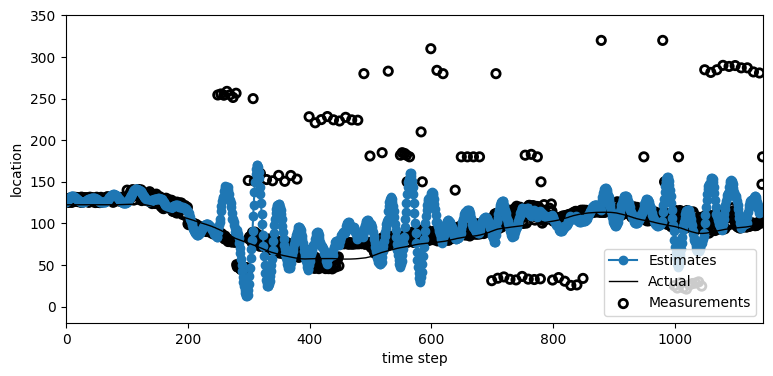

In [18]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_gh/png/method"+method+"_a1e1.png")
plt.savefig("images_gh/eps/method"+method+"_a1e1.eps")

In [19]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 25.870439690831667
The Absolute Squared Distance of estimates and actual path is 18.97458295486763
The KL Divergence between estimates and actual path is 0.029511250496812275
The Inverse KL Divergence between estimates and actual path is 0.03169473962918646


In [20]:
est = np.array(estimates)
np.savetxt("results_gh/method"+method+"/estimates_variation1.txt",est,fmt="%10.5f",delimiter=',',newline=',')

### Example 2

In [21]:
# Intial Hypothesis made by some pre-processing of the measurement data
weight = 175  # initial position
gain_rate = 5.0  # initial gain

# weight, gain_rate = initialize(weights) # initializing the filter output

In [22]:
estimates, predictions = gh_filter(weights, weight, gain_rate, weight_scale, gain_scale, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


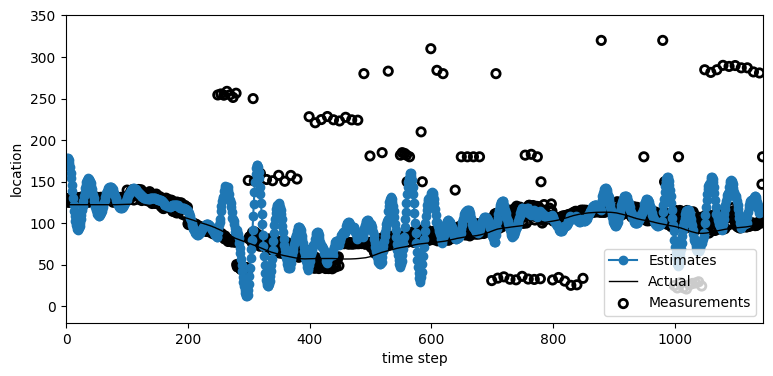

In [23]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_gh/png/method"+method+"_a1e2.png")
plt.savefig("images_gh/eps/method"+method+"_a1e2.eps")

In [24]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 26.564595701548612
The Absolute Squared Distance of estimates and actual path is 19.875780985922464
The KL Divergence between estimates and actual path is 0.030634417331961157
The Inverse KL Divergence between estimates and actual path is 0.032965485299377366


## Approach 2 - Outlier Detection using Running Average

### Algorithm

In [25]:
def gh_filter_developed(weights, weight, gain_rate, weight_scale1, weight_scale2, gain_scale1, gain_scale2, do_print=False):
    estimates, predictions = [weight], []
    ctr = 1
    running_average = 0.5
    flag = 0
    
    for z in weights:
        # outlier check step
        change = z - weight
        if abs(change) > 50*abs(running_average):
            flag = 1
        else:
            flag = 0
        if flag == 1:
            change = change / 50
        ctr = ctr + 1
        running_average = (running_average*(ctr-1) + change)/ctr
#         print(running_average)
        
        # prediction step
        weight = weight + gain_rate * time_step
        predictions.append(weight)
        predicted_weight = weight

        # update step
        residual = z - weight
        if flag == 0:
            gain_rate = gain_rate + gain_scale1 * (residual/time_step)
        else:
            gain_rate = gain_rate + gain_scale2 * (residual/time_step)
        if flag == 0:
            weight = weight + weight_scale1 * residual
        else:
            weight = weight + weight_scale2 * residual
        estimates.append(weight)
        estimated_weight = weight
        
        # Optional Printing Step
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)
    
    return [estimates, predictions]

### Example 1

In [26]:
# Intial Hypothesis made by some pre-processing of the measurement data
weight = weights[0]  # initial position
gain_rate = 1.0  # initial gain

# weight, gain_rate = initialize(weights) # initializing the filter output

In [27]:
# Time Step on which data is being measured with respect to the the time step on which initial
# gain is being assumed.
time_step = 1.0  # day

# The estimated value is kept something in between the predicted value and the measured value.
# scale = 0.5 means equal likelihood to both measurement and prediction.
# scale > 0.5 means measurement is given more likelihood of being true.
# scale < 0.5 means prediction is given more likelihood of being true.
weight_scale1 = 4.0/100
weight_scale2 = 4.0/1000

# The gain value is updated to something in between the initial value and the new value indicated by the
# next measurement and previous estimates.
# scale = 0.5 means equal likelihood to both new indicated value and initial value.
# scale > 0.5 means new indicated value is given more likelihood of being true.
# scale < 0.5 means initial value is given more likelihood of being true.
gain_scale1 = 1.0/30
gain_scale2 = 1.0/300

In [28]:
estimates, predictions = gh_filter_developed(weights, weight, gain_rate, weight_scale1, weight_scale2,
                                   gain_scale1, gain_scale2, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


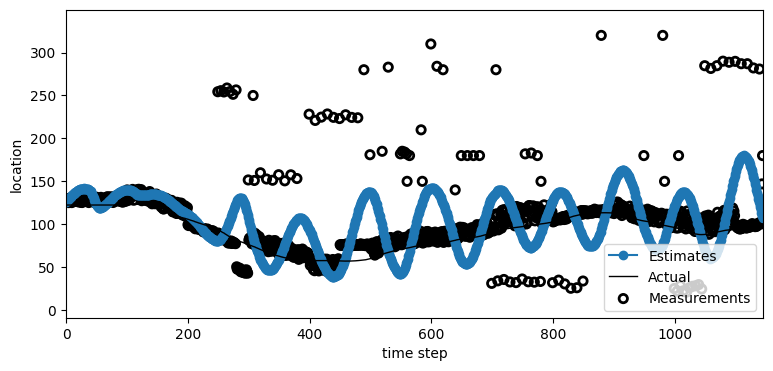

In [29]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_gh/png/method"+method+"_a2e1.png")
plt.savefig("images_gh/eps/method"+method+"_a2e1.eps")

In [30]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 31.47997228913403
The Absolute Squared Distance of estimates and actual path is 25.10716625206349
The KL Divergence between estimates and actual path is 0.04046480171703556
The Inverse KL Divergence between estimates and actual path is 0.04025550428338924


In [31]:
est = np.array(estimates)
np.savetxt("results_gh/method"+method+"/estimates_variation2.txt",est,fmt="%10.5f",delimiter=',',newline=',')

### Example 2

In [32]:
# Intial Hypothesis made by some pre-processing of the measurement data
weight = 150  # initial position
gain_rate = 1.0  # initial gain

# weight, gain_rate = initialize(weights) # initializing the filter output

In [33]:
estimates, predictions = gh_filter_developed(weights, weight, gain_rate, weight_scale1, weight_scale2,
                                   gain_scale1, gain_scale2, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


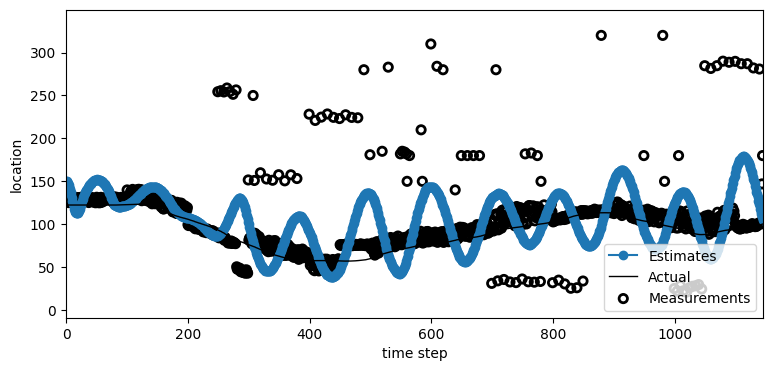

In [34]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_gh/png/method"+method+"_a2e2.png")
plt.savefig("images_gh/eps/method"+method+"_a2e2.eps")

In [35]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 31.586445354689026
The Absolute Squared Distance of estimates and actual path is 25.026917486494177
The KL Divergence between estimates and actual path is 0.04021334953192285
The Inverse KL Divergence between estimates and actual path is 0.039979460174019606


## Approach 3 - Global Outlier Detection

### Algorithm

In [36]:
def outlier_listmake(weights):
    mean = 0
    n = len(weights)
    sd = 0
    for z in weights:
        mean = mean + z
    mean = mean / n
    for z in weights:
        sd = sd + (z-mean)*(z-mean)
    sd = sd / n
    sd = math.sqrt(sd)
    outliers = []
    for i in range(n):
        z = weights[i]
        if z < mean - 3*sd:
            outliers.append(i)
        elif z > mean + 3*sd:
            outliers.append(i)
    return outliers

In [37]:
outliers = outlier_listmake(weights)

In [38]:
def gh_filter_developed2(weights, outliers, weight, gain_rate, weight_scale1, weight_scale2, 
                         gain_scale1, gain_scale2, do_print=False):
    estimates, predictions = [weight], []
    ctr = 0
    
    for (i, z) in enumerate(weights):
        # prediction step
        weight = weight + gain_rate * time_step
        predictions.append(weight)
        predicted_weight = weight

        # update step
        residual = z - weight
        if i != outliers[ctr]:
            gain_rate = gain_rate + gain_scale1 * (residual/time_step)
            weight = weight + weight_scale1 * residual
        else:
            gain_rate = gain_rate + gain_scale2 * (residual/time_step)
            weight = weight + weight_scale2 * residual
            ctr = ctr + 1
        estimates.append(weight)
        estimated_weight = weight
        
        # Optional Printing Step
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)
    
    return [estimates, predictions]

### Example 1

In [39]:
# Intial Hypothesis made by some pre-processing of the measurement data
weight = weights[0]  # initial position
gain_rate = 1.0  # initial gain

# weight, gain_rate = initialize(weights) # initializing the filter output

In [40]:
# Time Step on which data is being measured with respect to the the time step on which initial
# gain is being assumed.
time_step = 1.0  # day

# The estimated value is kept something in between the predicted value and the measured value.
# scale = 0.5 means equal likelihood to both measurement and prediction.
# scale > 0.5 means measurement is given more likelihood of being true.
# scale < 0.5 means prediction is given more likelihood of being true.
weight_scale1 = 4.0/100
weight_scale2 = 4.0/1000

# The gain value is updated to something in between the initial value and the new value indicated by the
# next measurement and previous estimates.
# scale = 0.5 means equal likelihood to both new indicated value and initial value.
# scale > 0.5 means new indicated value is given more likelihood of being true.
# scale < 0.5 means initial value is given more likelihood of being true.
gain_scale1 = 1.0/30
gain_scale2 = 1.0/300

In [41]:
estimates, predictions = gh_filter_developed(weights, weight, gain_rate, weight_scale1, weight_scale2,
                                   gain_scale1, gain_scale2, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


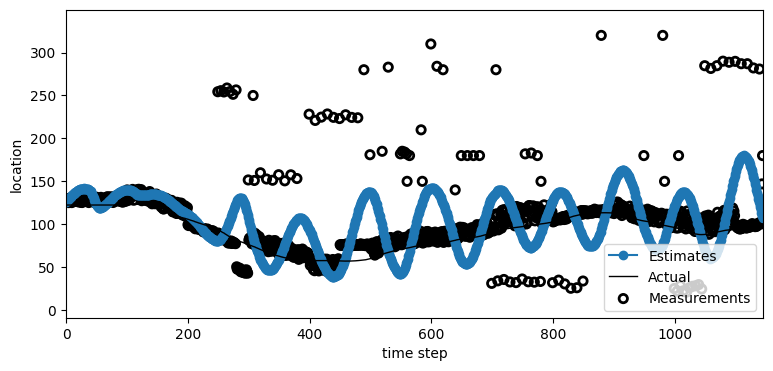

In [42]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_gh/png/method"+method+"_a3e1.png")
plt.savefig("images_gh/eps/method"+method+"_a3e1.eps")

In [43]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 31.47997228913403
The Absolute Squared Distance of estimates and actual path is 25.10716625206349
The KL Divergence between estimates and actual path is 0.04046480171703556
The Inverse KL Divergence between estimates and actual path is 0.04025550428338924


In [44]:
est = np.array(estimates)
np.savetxt("results_gh/method"+method+"/estimates_variation3.txt",est,fmt="%10.5f",delimiter=',',newline=',')

### Example 2

In [45]:
# Intial Hypothesis made by some pre-processing of the measurement data
weight = 150  # initial position
gain_rate = 1.0  # initial gain

# weight, gain_rate = initialize(weights) # initializing the filter output

In [46]:
estimates, predictions = gh_filter_developed(weights, weight, gain_rate, weight_scale1, weight_scale2,
                                   gain_scale1, gain_scale2, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


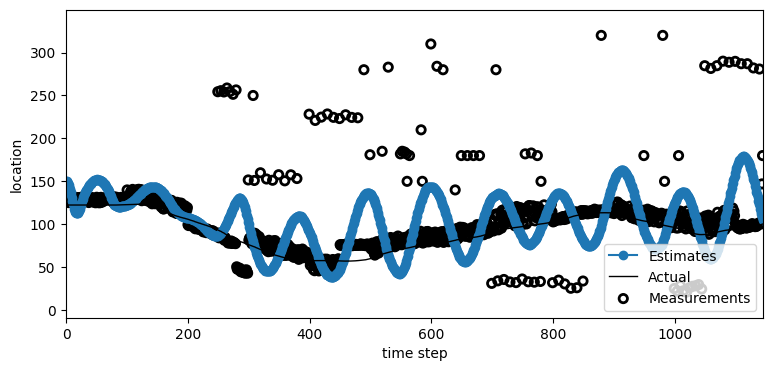

In [47]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_gh/png/method"+method+"_a3e2.png")
plt.savefig("images_gh/eps/method"+method+"_a3e2.eps")

In [48]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 31.586445354689026
The Absolute Squared Distance of estimates and actual path is 25.026917486494177
The KL Divergence between estimates and actual path is 0.04021334953192285
The Inverse KL Divergence between estimates and actual path is 0.039979460174019606
